# People Matching Algortihm

## Steps to be done

1. Prepare and clean the datasets
2. Calculate similarity within the two user groups
3. Assign mentor to each mentee based on similarity
3. Filter the assignments by the following preferences:
    * Mentee's priority nr 1: theatre, role, segment or gender
    * Mentor's prefered theatre
    * Mentor's prefered role
    * Mentor's prefered gender
4. Filter by mentor, if he/she has a mentee in mind
5. Shuffle the assignments until every mentee has a unique mentor assigned (shuffle top 4 mentors)
6. Exporting to excel sheet by ranking


# 1. Prepare and clean the datasets
## 1.1. Mentor Data

In [1]:
import pandas as pd
import scipy.spatial
import random
import xlsxwriter
import warnings
warnings.simplefilter("ignore")

In [2]:
# reed in mentor data
df_mentor_raw = pd.read_excel(r"FY21 - Chairman Mentor Interest Form.xlsx",sheet_name="Form1")

# check out data
df_mentor_raw.shape  #(91, 41)

(88, 42)

In [3]:
# function that drops a column if it contains only NaN values
def drop_nan_cols(df):
    nr = df.shape[0]
    for column in df.columns:
        if df[column].isnull().sum(axis = 0) == nr:
            df.drop([column], axis=1, inplace=True)
    return df

df_mentor_raw = drop_nan_cols(df_mentor_raw)
df_mentor_raw.shape  #(91, 29) removed 12 cols full of NaNs

(88, 30)

In [4]:
# remove first two entries since these were test entries
# df_mentor_raw.drop([0,1], axis=0, inplace=True)

# replace the numbered index by mentor names
df_mentor_raw = pd.DataFrame(df_mentor_raw).set_index('Name', drop=True)

In [5]:
df_mentor_raw.head()

,ID,Start time,Completion time,Email,How many Y2 CSAP Associates are you willing to mentor?,Gender,Are you a CSAP Alum?2,What is your CSAP Class FY?,Which track were you in?,Have you mentored an Early in Career before?,...,What was most challenging about the engagement and how did you overcome it?,Your country of residence,What are your general strengths?,What are your personal interests?,What do you think qualifies you to be a good mentor?2,What are your early expectations from this mentoring engagement?,Your linkedIn profile link,Have you already mentored for the Chairman Club Mentoring Program?,Any final comments or suggestions before you submit?,Let us know if you already have a CSAP mentee in mind
Name,,,,,,,,,,,,,,,,,,,,,
Luc Janssen,3,44172.664259,44172.668692,lujansse@cisco.com,1,M,No,NaN,NaN,No,...,NaN,Netherlands,Change management;Personal Brand;Critical thin...,Cycling;Cooking;Family;,"Expertise, open minded (learning is a two way ...",Providing guidance for career development (bra...,https://www.linkedin.com/in/lwjmajanssen/,No,NaN,NaN
Mary Catherine Dolehide,4,44172.664549,44172.672986,mdolehid@cisco.com,1,F,No,NaN,NaN,No,...,NaN,US,Collaboration;Customer interaction;Accountabil...,"Family;Individual sports (golf, running);Travel;",Over my 30 years in technology sales for both ...,To share my 30 years of sales experience and r...,Mary Catherine Dolehide,No,NaN,NaN
Leonora Steger,5,44172.664109,44172.674931,lronga@cisco.com,2,F,Yes,FY08,ASE,No,...,NaN,USA,Customer interaction;Effective listening;Coach...,Cooking;Family;Reading;,I think a good mentor should be open to commun...,I have mentored before but not through a specf...,https://www.linkedin.com/in/leonorasteger/,No,I would like to be selected as I think I have ...,NaN
Steve Fuchs,6,44172.672431,44172.675799,stefuchs@cisco.com,2,M,No,NaN,NaN,NaN,...,Focus differences between myself and mentee. ...,United States,Accountability;Coaching;Critical thinking;,Photography;Pets;,"Listening, guidance, availability to discuss a...",not alot. many people don't spend the time.,www.linkedin/in/fuchssteven,Yes,NaN,NaN
Chase Abrams,7,44172.664606,44172.676713,chabrams@cisco.com,1,M,No,NaN,NaN,No,...,NaN,USA,Accountability;Customer interaction;Goal setting;,"Individual sports (golf, running);Tech hobbies...",I think I'd qualify as a good mentor for many ...,I'm 36 years old and have been in technology s...,https://www.linkedin.com/in/chase-abrams/,No,I'd love to get involved and help!,NaN


Up to this point, the dataset is clean from data we do not need for matching. 

In [6]:
type(df_mentor_raw)

pandas.core.frame.DataFrame

In [7]:
#df_mentor_raw.isnull().sum(axis = 0)

In [8]:
df_mentor = df_mentor_raw[["What are you most likely to give in this mentoring engagement?",
                           "What are your general strengths?",
                           "What are your personal interests?"]]

#df_mentor.head()

In [9]:
# function that splits the choices in the colums by ; to and adds them to a list
def extract_choices(df_col):
    choices = []
    cols = set()
    data = set(df_col)
    for choice in data:
        choice = choice.split(";")
        choices.append(choice)
    for innerlist in choices:
        for choice in innerlist:
            if choice != "":
                cols.add(choice)    
        
    return list(cols)

give_mentor = extract_choices(df_mentor["What are you most likely to give in this mentoring engagement?"])
strengths_mentor = extract_choices(df_mentor["What are your general strengths?"])
interests_mentor = extract_choices(df_mentor["What are your personal interests?"])

In [10]:
# make one hot df

def encode_onehot(df_input, df_output):
    count = 0
    for answer in df_output.columns:
        for column in df_input.columns:
            for result in df_input[column]:
                if answer in result: 
                    df_output.loc[df_output.index[count], answer] = 1           #.iloc[:,2:3]               
                                       
                if count == (len(df_input.index)-1):
                    count = 0
                else:
                    count += 1
    df_output = df_output.fillna(0)
    return df_output

### 1.1.1. Mentor Question 1: What are you most likely to give in this mentoring engagement?

This section creates a onehot encoded dataframe of the answers given by the mentors to this question.

The responses were classifies into 4 main types: 
* **General Advice**
* **Specific Advice**
* **Day to Day Advice**
* **Own Advice**

The following responses were edited, due to their multiple meanings:
* **All or any of the above** --> matches all the 4 response types
* **I'm flexible and will adapt to my mentee's goals** --> matches all the 4 response types

The following responses (recorded in the "others" field) were merged as following:
* **Contact Center knowledge transfer** -->  matches *Specific Advice*
* **how to become a trusted advisor and support customer with strategic planning** --> matches *Own Advice*
* **Sharing my own career journey and lessons learnt** --> matches *Own Advice*
* **An out of the box angle back on a situation.** --> matches *Own Advice*

In [11]:
df_give_mentor = encode_onehot(df_mentor, pd.DataFrame([], index=df_mentor.index, columns=give_mentor))

In [12]:
df_give_mentor.head()

,an out of the box angle back on a situation.,General strategic career advice depending on mentee goals,Tactical day to day situations & problem solving,I'm flexible and will adapt to my mentee's goals,Sharing my own career journey and lessons learnt,Specific career advice to prepare for next role,all or any of the above,how to become a trusted advisor and support customer with strategic planning
Name,,,,,,,,
Luc Janssen,0,1,1,0,1,1,0,0
Mary Catherine Dolehide,0,0,0,1,0,0,0,0
Leonora Steger,0,0,0,1,0,0,0,0
Steve Fuchs,0,1,1,1,1,1,0,0
Chase Abrams,0,0,0,1,0,0,0,0


In [13]:
# function to combine multiple onehot encoded columns into one and optionally adding to new df
def combine_cols(df, combine_cols, add_to_df="no", combine_name=None):
    for col in combine_cols:
        if col == combine_cols[0]:
            result_list = list(df[col])
        else:
            result_list = [x + y for x, y in zip(result_list, list(df[col]))]
            
    result_list = [1 if x>1 else x for x in result_list]
            
    if type(add_to_df) == pd.core.frame.DataFrame:
        add_to_df[combine_name] = result_list
        add_to_df.set_index(df.index.values, inplace=True)
        return add_to_df
    else:
        return result_list

In [14]:
df_give_mentor_final = pd.DataFrame()

# combining the columns
cols = ["General strategic career advice depending on mentee goals", 
        "all or any of the above", 
        "I'm flexible and will adapt to my mentee's goals"]
df_give_mentor_final = combine_cols(df_give_mentor, cols, add_to_df=df_give_mentor_final, combine_name="general_advice")

# Specific advice
cols = ["all or any of the above", # own answer
        "I'm flexible and will adapt to my mentee's goals",
        "Specific career advice to prepare for next role"]
df_give_mentor_final = combine_cols(df_give_mentor, cols, add_to_df=df_give_mentor_final, combine_name="specific_advice")

# Advice of day to day situations & problem solving
cols = ["Tactical day to day situations & problem solving", 
        "all or any of the above", 
        "I'm flexible and will adapt to my mentee's goals"]
df_give_mentor_final = combine_cols(df_give_mentor, cols, add_to_df=df_give_mentor_final, combine_name="day2day_advice")

# Own experience
cols = ["how to become a trusted advisor and support customer with strategic planning ", # own answer
        "Sharing my own career journey and lessons learnt", 
        "an out of the box angle back on a situation. ", # own answer
        "all or any of the above", 
        "I'm flexible and will adapt to my mentee's goals"]
df_give_mentor_final = combine_cols(df_give_mentor, cols, add_to_df=df_give_mentor_final, combine_name="own_advice")


This is the final one hot encoded dataframe of the answers to Mentor Question 1:

In [15]:
df_give_mentor_final.head()

,general_advice,specific_advice,day2day_advice,own_advice
Luc Janssen,1,1,1,1
Mary Catherine Dolehide,1,1,1,1
Leonora Steger,1,1,1,1
Steve Fuchs,1,1,1,1
Chase Abrams,1,1,1,1


### 1.1.2. Mentor Question 2: What are you general strengths?

This section creates a onehot encoded dataframe of the answers given by the mentors to this question.

The following responses (recorded in the "others" field) were merged as following:
* **Social Media** -->  matches *Creativity/Innovation*
* **Rapport Building** --> matches *Customer Interaction* and *Crucial Conversations*
* **Team building** --> matches *Empowerment* and *Recognition*
* **Collaboration** --> matches *Productivity*
* **Accountability** --> matches *Recognition*

In [16]:
df_strengths_mentor = encode_onehot(df_mentor, pd.DataFrame([], index=df_mentor.index, columns=strengths_mentor))

In [17]:
df_strengths_mentor.head()

,Decision making,Goal setting,Critical thinking,Customer interaction,Competitive strategy,Transition career path,Cross-architecture,Productivity,Recognition,Design thinking,...,Time management,Story telling,Finance,Personal Brand,Negotiating,Influencing,Creativity / innovation,Technical knowledge,Change management,Team building
Name,,,,,,,,,,,,,,,,,,,,,
Luc Janssen,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
Mary Catherine Dolehide,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Leonora Steger,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Steve Fuchs,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chase Abrams,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_strengths_mentor_final = pd.DataFrame()
exclude = []

# Customer interaction & Rapport Building
cols = ["Customer interaction", 
        "Rapport Building"] # own answer
df_strengths_mentor_final = combine_cols(df_strengths_mentor, cols, add_to_df=df_strengths_mentor_final, combine_name="Customer interaction")
exclude.append(cols)

# Crucial Conversations & Rapport Building
cols = ["Crucial conversations", 
        "Rapport Building"] # own answer
df_strengths_mentor_final = combine_cols(df_strengths_mentor, cols, add_to_df=df_strengths_mentor_final, combine_name="Crucial conversations")
exclude.append(cols)

exclude = [item for sublist in exclude for item in sublist]

In [19]:
for column in df_strengths_mentor.columns: 
    if column not in exclude:
        df_strengths_mentor_final[column] = list(df_strengths_mentor[column])

In [20]:
df_strengths_mentor_final.head()

,Customer interaction,Crucial conversations,Decision making,Goal setting,Critical thinking,Competitive strategy,Transition career path,Cross-architecture,Productivity,Recognition,...,Time management,Story telling,Finance,Personal Brand,Negotiating,Influencing,Creativity / innovation,Technical knowledge,Change management,Team building
Luc Janssen,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
Mary Catherine Dolehide,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Leonora Steger,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Steve Fuchs,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chase Abrams,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.1.2. Mentor Question 3: What are your personal interests?

This section creates a onehot encoded dataframe of the answers given by the mentors to this question.

The following responses (recorded in the "others" field) were merged as following:
* **My work. I know this sounds pleasing but it is the truth** -->  no match
* **Ranching** --> matches *Pets*
* **Car racing** --> matches *Extreme sports (sky diving)*
* **Creating technology video** --> matches *Tech hobbies* and *Photography*
* **Cycling** --> matches *Individual sports (golf, running)*
* **Automobile and Motorcycles collecting and building** --> matches *Puzzles & games*
* **yoga** --> matches *Individual sports (golf, running)*
* **Golf** --> matches *Individual sports (golf, running)*
* **Boating** --> matches *Individual sports (golf, running)*
* **Flying** --> matches *Travel*
* **Skiing and Scuba Diving** --> matches *Extreme sports (sky diving)* and *Individual sports (golf, running)*
* **karate** --> matches *Individual sports (golf, running)*
* **Diving** --> matches *Extreme sports (sky diving)*

In [21]:
df_interests_mentor = encode_onehot(df_mentor, pd.DataFrame([], index=df_mentor.index, columns=interests_mentor))

In [22]:
df_interests_mentor.columns

Index(['Cycling', 'Working out', 'Volunteering', 'Photography', 'Boating',
       'Culture', 'Reading', 'yoga', 'Chess', 'Religion', 'Ranching',
       'Shopping/fashion', 'Diving', 'Dance',
       'My work. I know this sounds pleasing but it is the truth', 'Gardening',
       'Family', 'Car racing', 'Art', 'Tech hobbies', 'Politics',
       'Creating technology video', 'Travel', 'Meditation', 'karate', 'Music',
       'Skiing and Scuba Diving', 'Golf', 'Extreme sports (sky diving)',
       'Puzzles & games', 'Pets', 'Flying',
       'Automobile and Motorcycles collecting and building', 'Design',
       'Individual sports (golf, running)', 'Social networking',
       'Wine tasting', 'Team sports (soccer, football)', 'Cooking'],
      dtype='object')

In [23]:
df_interests_mentor_final = pd.DataFrame()

# Pets & Ranching
cols = ["Pets", 
        "Ranching"] # own answer
df_interests_mentor_final = combine_cols(df_interests_mentor, cols, add_to_df=df_interests_mentor_final, combine_name="Pets")
exclude.append(cols)

# Extreme sports (sky diving) & Car racing & Skiing and Scuba Diving & Diving
cols = ["Extreme sports (sky diving)",
        "Car racing",
        "Skiing and Scuba Diving",# own answer
        "Diving"] # own answer
df_interests_mentor_final = combine_cols(df_interests_mentor, cols, add_to_df=df_interests_mentor_final, combine_name="Extreme sports (sky diving)")
exclude.append(cols)

# Tech Hobbies & Creating technology video
cols = ["Tech hobbies",
        "Creating technology video"] # own answer
df_interests_mentor_final = combine_cols(df_interests_mentor, cols, add_to_df=df_interests_mentor_final, combine_name="Tech Hobbies")
exclude.append(cols)

# Photography & Creating technology video &
cols = ["Photography",
        "Creating technology video"] # own answer
df_interests_mentor_final = combine_cols(df_interests_mentor, cols, add_to_df=df_interests_mentor_final, combine_name="Photography")
exclude.append(cols)

# Individual sports (golf, running) & Creating technology video &
cols = ["Individual sports (golf, running)",
        "Cycling", # own answer
        "yoga", # own answer
        "Golf", # own answer
        "Boating", # own answer
        "Skiing and Scuba Diving", # own answer
        "karate"] # own answer
df_interests_mentor_final = combine_cols(df_interests_mentor, cols, add_to_df=df_interests_mentor_final, combine_name="Individual sports (golf, running)")
exclude.append(cols)

# Puzzles & games & Automobile and Motorcycles collecting and building
cols = ["Puzzles & games",
        "Automobile and Motorcycles collecting and building"] # own answer
df_interests_mentor_final = combine_cols(df_interests_mentor, cols, add_to_df=df_interests_mentor_final, combine_name="Puzzles & games")
exclude.append(cols)

# Travel & Flying
cols = ["Travel",
        "Flying"] # own answer
df_interests_mentor_final = combine_cols(df_interests_mentor, cols, add_to_df=df_interests_mentor_final, combine_name="Travel")
exclude.append(cols)

exclude = [item for sublist in exclude for item in sublist]

In [24]:
for column in df_interests_mentor.columns: 
    if column == "ID" or column == "My work. I know this sounds pleasing but it is the truth":
        continue
    if column not in exclude:
        df_interests_mentor_final[column] = list(df_interests_mentor[column])

In [25]:
df_interests_mentor_final.head()

,Pets,Extreme sports (sky diving),Tech Hobbies,Photography,"Individual sports (golf, running)",Puzzles & games,Travel,Working out,Volunteering,Culture,...,Family,Art,Politics,Meditation,Music,Design,Social networking,Wine tasting,"Team sports (soccer, football)",Cooking
Luc Janssen,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
Mary Catherine Dolehide,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Leonora Steger,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
Steve Fuchs,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chase Abrams,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.1.4. Combine all three mentor dataframes into one

The dataframes containing the Mentor's andwers "advice to give", "strengths" and "personal interests" are combined into one single one-hot encoded dataframe.

In [26]:
df_onehot_mentor = pd.concat([df_give_mentor_final, df_strengths_mentor_final,df_interests_mentor_final], axis=1)
df_onehot_mentor = df_onehot_mentor.reindex(sorted(df_onehot_mentor.columns), axis=1)

In [27]:
df_onehot_mentor.head()

,Accountability,Art,Change management,Chess,Coaching,Collaboration,Communications (public speaking),Competitive strategy,Cooking,Creativity / innovation,...,Transition career path,Travel,Volunteering,Wine tasting,Work / Life balance,Working out,day2day_advice,general_advice,own_advice,specific_advice
Luc Janssen,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,1
Mary Catherine Dolehide,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,1,1
Leonora Steger,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,1
Steve Fuchs,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
Chase Abrams,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1


## 1.2. Mentee data

Now we repeat the process with the Mentee data.

In [28]:
# read in mentee data
df_mentee_raw = pd.read_excel(r'FY21 - Mentee Interest - Chairman Club & Hall of Fame Mentoring Program.xlsx',sheet_name='Form1')
df_mentee_raw = pd.DataFrame(df_mentee_raw).set_index('Name', drop=True)
df_mentee_raw.shape

(66, 24)

In [29]:
df_mentee_raw = drop_nan_cols(df_mentee_raw)
df_mentee_raw.shape

# no columns had all NaNs

(66, 24)

In [30]:
df_mentee = df_mentee_raw[["What are you most likely to want out of this mentoring engagement?",
               "What are the strengths you would like to further develop?",
               "What are your personal interests?"]]

In [31]:
want_mentee = extract_choices(df_mentee["What are you most likely to want out of this mentoring engagement?"])
strengths_mentee = extract_choices(df_mentee["What are the strengths you would like to further develop?"])
interests_mentee = extract_choices(df_mentee["What are your personal interests?"])

### 1.2.1. Mentee Question 1: What are you most likely to want out of this mentoring engagement?

This section creates a onehot encoded dataframe of the answers given by the mentees to this question.

The responses were classifies into 4 main types: 
* **General Advice**
* **Specific Advice**
* **Day to Day Advice**
* **Own Advice**

The following responses (recorded in the "others" field) were edited in order to not skew the people matching. If a mentee chooses this, he/she will always be more different than each of the mentors, since no mentor will meet this creteria. 
* **Form a strategic plan on how to become the best (or the mindset that will help me do)**
* **situational experiences (wins and losses) Want to hear their perspective on how to be a good team player Want to hear their thoughts on market changes and where tech, energy and agriculture are headed.**

All responses were add to the **Own Advice** type, since otherwise the data would aswell be skewed. Now it has no impact on the mentee side of data.

In [32]:
df_want_mentee = encode_onehot(df_mentee, pd.DataFrame([], index=df_mentee.index, columns=want_mentee))

In [33]:
df_want_mentee.head()

,General strategic career advice,Tactical day to day situations & problem solving,Form a strategic plan on how to become the best (or the mindset that will help me do),How one could maximize the talent and potential,Anything that they wish they had known in my situation,Specific career advice to prepare for next role,How to build better relationships with customers and partners /,"Looking to hear about how they handle pressure, situational experiences (wins and losses) Want to hear their perspective on how to be a good team player Want to hear their thoughts on market changes and where tech, energy and agriculture are headed.",Know/uncover my strengths and differentiators
Name,,,,,,,,,
Ana Tojeiro,1,0,0,0,0,0,0,0,0
Yosephine Gita Asaria Hutauruk,1,1,0,0,0,0,0,0,0
Nikolaos Papadopoulos,1,0,0,0,0,0,0,0,0
Lucia Caiata,1,0,0,0,0,0,0,0,0
Radhika Paliwal,1,1,0,0,0,1,0,0,0


In [34]:
df_want_mentee_final = pd.DataFrame()
exclude = []

# combining the columns
cols = ["Form a strategic plan on how to become the best (or the mindset that will help me do)", 
        "General strategic career advice", 
        "Looking to hear about how they handle pressure, situational experiences (wins and losses) Want to hear their perspective on how to be a good team player Want to hear their thoughts on market changes and where tech, energy and agriculture are headed. "]
df_want_mentee_final = combine_cols(df_want_mentee, cols, add_to_df=df_want_mentee_final, combine_name="general_advice")
exclude.append(cols)

# Specific advice
cols = ["Form a strategic plan on how to become the best (or the mindset that will help me do)", # own answer
        "Specific career advice to prepare for next role", 
        "Looking to hear about how they handle pressure, situational experiences (wins and losses) Want to hear their perspective on how to be a good team player Want to hear their thoughts on market changes and where tech, energy and agriculture are headed. ",
        "How one could maximize the talent and potential",
        "How to build better relationships with customers and partners / "]
df_want_mentee_final = combine_cols(df_want_mentee, cols, add_to_df=df_want_mentee_final, combine_name="specific_advice")
exclude.append(cols)

# Advice of day to day situations & problem solving
cols = ["Form a strategic plan on how to become the best (or the mindset that will help me do)", # own answer
        "Tactical day to day situations & problem solving", 
        "Looking to hear about how they handle pressure, situational experiences (wins and losses) Want to hear their perspective on how to be a good team player Want to hear their thoughts on market changes and where tech, energy and agriculture are headed. "]
df_want_mentee_final = combine_cols(df_want_mentee, cols, add_to_df=df_want_mentee_final, combine_name="day2day_advice")
exclude.append(cols)

# Own experience
cols = ["Form a strategic plan on how to become the best (or the mindset that will help me do)", 
        "General strategic career advice", 
        "Specific career advice to prepare for next role",
        "Tactical day to day situations & problem solving", 
        "Looking to hear about how they handle pressure, situational experiences (wins and losses) Want to hear their perspective on how to be a good team player Want to hear their thoughts on market changes and where tech, energy and agriculture are headed. ",
        "Anything that they wish they had known in my situation",
        "Know/uncover my strengths and differentiators"]
df_want_mentee_final = combine_cols(df_want_mentee, cols, add_to_df=df_want_mentee_final, combine_name="own_advice")
exclude.append(cols)

exclude = [item for sublist in exclude for item in sublist]

In [35]:
for column in df_want_mentee.columns: 
    if column not in df_want_mentee_final.columns and column not in exclude:
        df_want_mentee_final[column] = list(df_want_mentee[column])

In [36]:
#df_want_mentee_final.head()

### 1.2.2. Mentee Question 2: What are the strengths you'd like to further develop?

This section creates a onehot encoded dataframe of the answers given by the mentees to this question.

In [37]:
# with ID column
df_strengths_mentee_final = encode_onehot(df_mentee, pd.DataFrame([], index=df_mentee.index, columns=strengths_mentee))

#df_strengths_mentee_final = encode_onehot(df_mentee, strengths_mentee)

In [38]:
df_strengths_mentee_final.head()

,Decision making,Goal setting,Critical thinking,Customer interaction,Competitive strategy,Transition career path,Cross-architecture,Productivity,Recognition,Design thinking,...,Time management,Story telling,Finance,Personal Brand,Negotiating,Influencing,Creativity / innovation,Technical knowledge,Change management,Team building
Name,,,,,,,,,,,,,,,,,,,,,
Ana Tojeiro,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
Yosephine Gita Asaria Hutauruk,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,0,0
Nikolaos Papadopoulos,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,1,1,0,0
Lucia Caiata,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Radhika Paliwal,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### 1.2.3. Mentee Question 3: What are your personal interests?

This section creates a onehot encoded dataframe of the answers given by the mentees to this question.

The following responses (recorded in the "others" field) were merged as following:
* **Pen and Paper role-playing games (e.g. Dungeons & Dragons)** -->  matches *Puzzles & Games*
* **Programming (just beginning to learn!)** --> matches *Tech hobbies*
* **Coffee** --> matches *Cooking*

In [39]:
df_interests_mentee = encode_onehot(df_mentee, pd.DataFrame([], index=df_mentee.index, columns=interests_mentee))

In [40]:
df_interests_mentee.columns

Index(['Programming (just beginning to learn!)', 'Working out', 'Volunteering',
       'Photography', 'Culture', 'Reading', 'Chess', 'Coffee', 'Religion',
       'Shopping/fashion', 'Dance', 'Gardening', 'Family', 'Art',
       'Pen and Paper role-playing games (e.g. Dungeons & Dragons)',
       'Stock market', 'Tech hobbies', 'Politics', 'Travel', 'Meditation',
       'Music', 'Psychology ', 'Extreme sports (sky diving)',
       'Puzzles & games', 'Pets', 'Design',
       'Individual sports (golf, running)', 'Social networking',
       'Wine tasting', 'Team sports (soccer, football)', 'Cooking'],
      dtype='object')

In [41]:
df_interests_mentee_final = pd.DataFrame()
exclude = []

# Pets & Ranching
cols = ["Puzzles & games", 
        "Pen and Paper role-playing games (e.g. Dungeons & Dragons)"] # own answer
df_interests_mentee_final = combine_cols(df_interests_mentee, cols, add_to_df=df_interests_mentee_final, combine_name="Puzzles & games")
exclude.append(cols)

# Extreme sports (sky diving) & Car racing & Skiing and Scuba Diving & Diving
cols = ["Cooking",
        "Coffee"] # own answer
df_interests_mentee_final = combine_cols(df_interests_mentee, cols, add_to_df=df_interests_mentee_final, combine_name="Cooking")
exclude.append(cols)

# Tech Hobbies & Creating technology video
cols = ["Tech hobbies",
        "Programming (just beginning to learn!)"] # own answer
df_interests_mentee_final = combine_cols(df_interests_mentee, cols, add_to_df=df_interests_mentee_final, combine_name="Tech Hobbies")
exclude.append(cols)

# Stock market added to Finance strengths
for mentee in df_interests_mentee.index:
    if df_interests_mentee["Stock market"][mentee] == 1:
        df_strengths_mentee_final["Finance"][mentee] = 1
exclude.append(["Stock market"])

# Stock market added to Influencing and Negotiating strengths
for mentee in df_interests_mentee.index:
    if df_interests_mentee["Psychology "].loc[mentee] == 1:
        df_strengths_mentee_final["Influencing"].loc[mentee] = 1
        df_strengths_mentee_final["Negotiating"].loc[mentee] = 1
exclude.append(["Psychology "])

exclude = [item for sublist in exclude for item in sublist]

In [42]:
for column in df_interests_mentee.columns: 
    if column not in exclude:
        df_interests_mentee_final[column] = list(df_interests_mentee[column])

In [43]:
df_interests_mentee_final.columns

Index(['Puzzles & games', 'Cooking', 'Tech Hobbies', 'Working out',
       'Volunteering', 'Photography', 'Culture', 'Reading', 'Chess',
       'Religion', 'Shopping/fashion', 'Dance', 'Gardening', 'Family', 'Art',
       'Politics', 'Travel', 'Meditation', 'Music',
       'Extreme sports (sky diving)', 'Pets', 'Design',
       'Individual sports (golf, running)', 'Social networking',
       'Wine tasting', 'Team sports (soccer, football)'],
      dtype='object')

### 1.2.4. Combine all three mentee dataframes into one:

In [44]:
df_onehot_mentee = pd.concat([df_want_mentee_final, df_strengths_mentee_final, df_interests_mentee_final], axis=1)
df_onehot_mentee = df_onehot_mentee.reindex(sorted(df_onehot_mentee.columns), axis=1)

In [45]:
df_onehot_mentee.head()

,Accountability,Art,Change management,Chess,Coaching,Collaboration,Communications (public speaking),Competitive strategy,Cooking,Creativity / innovation,...,Transition career path,Travel,Volunteering,Wine tasting,Work / Life balance,Working out,day2day_advice,general_advice,own_advice,specific_advice
Name,,,,,,,,,,,,,,,,,,,,,
Ana Tojeiro,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
Yosephine Gita Asaria Hutauruk,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,1,1,0
Nikolaos Papadopoulos,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
Lucia Caiata,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
Radhika Paliwal,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,1,1,1,1


## 1.3. Check the dataframes for errors

In [46]:
df_interests_mentee_final.columns

Index(['Puzzles & games', 'Cooking', 'Tech Hobbies', 'Working out',
       'Volunteering', 'Photography', 'Culture', 'Reading', 'Chess',
       'Religion', 'Shopping/fashion', 'Dance', 'Gardening', 'Family', 'Art',
       'Politics', 'Travel', 'Meditation', 'Music',
       'Extreme sports (sky diving)', 'Pets', 'Design',
       'Individual sports (golf, running)', 'Social networking',
       'Wine tasting', 'Team sports (soccer, football)'],
      dtype='object')

In [47]:
df_strengths_mentee_final.columns

Index(['Decision making', 'Goal setting', 'Critical thinking',
       'Customer interaction', 'Competitive strategy',
       'Transition career path', 'Cross-architecture', 'Productivity',
       'Recognition', 'Design thinking', 'Communications (public speaking)',
       'Accountability', 'Providing feedback', 'Work / Life balance',
       'Empowerment', 'Delegating', 'Collaboration', 'Effective listening',
       'Social Media', 'Coaching', 'Prioritization', 'Crucial conversations',
       'Time management', 'Story telling', 'Finance', 'Personal Brand',
       'Negotiating', 'Influencing', 'Creativity / innovation',
       'Technical knowledge', 'Change management', 'Team building'],
      dtype='object')

In [48]:
# same columns
for cols in df_onehot_mentee.columns:
    if cols not in df_onehot_mentor.columns:
        print(cols)

In [49]:
for cols in df_onehot_mentor.columns:
    if cols not in df_onehot_mentee.columns:
        print(cols)

# 2. Calculating Similarity of Users

In [50]:
# calculate the Jaccard distance between each mentee and each mentor
# 1-Jaccard distance = similarity between pairs
ary = scipy.spatial.distance.cdist(df_onehot_mentor.iloc[:,1:], df_onehot_mentee.iloc[:,1:], metric='jaccard')

people_similarity = pd.DataFrame(ary, columns=df_onehot_mentee.index.values, index=df_onehot_mentor.index.values)
people_similarity.head()

,Ana Tojeiro,Yosephine Gita Asaria Hutauruk,Nikolaos Papadopoulos,Lucia Caiata,Radhika Paliwal,Gabriele Antonio Innocenti,Basel Iskandarani,Eva Roussou,Gurmeet Johal,Felix Neulinger,...,Alberto Muinos Olego,Josef Kandelan,Marie-Morgane Kergrohenn,Vanessa Fakhoury,Pauline Seral,Ida Videcrantz,Ali Belhajjame,Ignacio Fite,Previn Wong,Regina Pascual
Luc Janssen,0.842105,0.857143,0.850000,0.800000,0.750000,0.882353,0.647059,0.814815,0.692308,0.750000,...,0.791667,0.777778,0.714286,0.714286,0.600000,0.800000,0.666667,0.714286,0.791667,0.800000
Mary Catherine Dolehide,0.764706,0.789474,0.777778,0.850000,0.642857,0.800000,0.533333,0.851852,0.777778,0.642857,...,0.727273,0.814815,0.866667,0.692308,0.823529,0.866667,0.733333,0.700000,0.727273,0.785714
Leonora Steger,0.900000,0.800000,0.722222,0.857143,0.750000,0.882353,0.647059,0.857143,0.785714,0.666667,...,0.681818,0.730769,0.800000,0.800000,0.764706,0.800000,0.750000,0.772727,0.791667,0.714286
Steve Fuchs,0.823529,0.842105,0.894737,0.900000,0.714286,0.785714,0.764706,0.888889,0.814815,0.714286,...,0.714286,0.851852,0.857143,0.857143,0.812500,0.857143,0.714286,0.863636,0.826087,0.857143
Chase Abrams,0.833333,0.647059,0.777778,0.789474,0.642857,0.875000,0.705882,0.807692,0.777778,0.642857,...,0.727273,0.769231,0.866667,0.785714,0.823529,0.785714,0.642857,0.700000,0.666667,0.785714


In [51]:
# check which pair has the highest similarity in the dataset
a, b = people_similarity.stack().idxmin()
print(people_similarity.loc[[a], [b]])

                       Basel Iskandarani
Mumtaz Bee Abdul Rauf           0.307692


# 3. Assigning Mentor - Mentee Pairs

In [52]:
# function that assigns the list of mentors ranked by similarity to each mentee
def create_cluster(df):
    clusters = {}
    for mentee in df.columns:
        mentee_cluster = df[mentee].nsmallest(len(df))
        data = {mentee : list(mentee_cluster.index)}
        clusters.update(data)
    return clusters

In [53]:
people_cluster = create_cluster(people_similarity)

# 4. Filter assignments by mentee/mentor preferences
We now have a ranking of the mentors that are most similar to the respective mentees. Each mentee has a list of the mentors ranked by their similarity regarding the survey choices.

Now we consider special preferences that the mentees/mentors chose within the survey.

The order of priorities considered is as following:

1. First preference of mentee 
2. Theatre preference of mentor
3. Role preference of mentor

In [54]:
# test to check if each mentee has at least 1 metor assigned to it
def test_assignment(info="default"):
    for mentee in people_cluster:
        if len(people_cluster[mentee]) < 1:
            raise ValueError(mentee, "has less than 1 mentor assigned! Info:", info)
    print("Test passed.")

## 4.1. Prepare Data: Theatre

### 4.1.1. Mentor: Theatre

In [55]:
df_mentor_theatre = df_mentor_raw[["Would you prefer a mentee in the same theatre?", 
                                "Your theatre?"]]
                                #"Your segment?",
                                #"Would you prefer a mentee in a:", #sales or technical role
                                #"Would you prefer a mentee of the same gender?"]]

# filter by all the mentors that want a mentee in the same theatre
df_mentor_theatre_filter = df_mentor_theatre[df_mentor_theatre["Would you prefer a mentee in the same theatre?"]!="No preference"]

### 4.1.2. Mentee: Theatre

In [56]:
df_mentee_theatre = df_mentee_raw[["If possible, would you prefer a mentor in the same theatre?", 
                                   "Your theatre?"]]
df_mentee_theatre_filter = df_mentee_theatre[df_mentee_theatre["If possible, would you prefer a mentor in the same theatre?"]!="No preference"]

## 4.2. Prepare Data: Role
### 4.2.1. Mentor: Role

In [57]:
df_mentor_role = df_mentor_raw[["Would you prefer a mentee in a:", 
                                "What is your title?"]]

# filter by all the mentors that want a mentee in the same theatre
df_mentor_role_filter = df_mentor_role[df_mentor_role["Would you prefer a mentee in a:"]!="No preference"]

In [58]:
def replace_roles(df, col):
    technical = ["technical", "system", "se", "Technichal",
                 "Justin Flateau"] # systems atchitect
    sales = ["account manager", "business development", "client", "sales specialist", "financial", "partner", 
             "regional director", "sales manager", "renewal", "business solutions", "regional manager", "cx",
             "bdm", "product specialist", "Collaboration Executive", "Account Specialist", "vsam", "vpam",
             "Joyce Huan Wang", # global AM
             "Susuk-Bujang", # AM
             "Missus Kergrohenn Marie-Morgane "] #vsam
    for person in df.index:
        person_role = (df[col].loc[person]).lower()
        if person == "Toby Rees":
            df[col][person] = "Technical role"
        if person == "Mark Sibuns":
            df[col][person] = "Sales role"
        if person == "Deepti Babber":
            df[col][person] = "Technical role"

        for tech_role in technical:
            if tech_role.lower() in person_role:
                df[col][person] = "Technical role"
        for sales_role in sales:
            if sales_role.lower() in person_role:
                df[col][person] = "Sales role"

In [59]:
replace_roles(df_mentor_role, "What is your title?")

In [60]:
def test_roles(df, col):
    if len(set(df[col])) > 2:
        raise ValueError("Error! Roles other than Sales & Technical Role present in dataset.")
    else:
        print("Test passed.")

In [61]:
test_roles(df_mentor_role, "What is your title?")

Test passed.


### 4.2.2. Mentee: Role

In [62]:
df_mentee_role = df_mentee_raw[["If possible, would you prefer a mentor in a:", 
                                "What is your title?"]]
df_mentee_role_filter = df_mentee_role[df_mentee_role["If possible, would you prefer a mentor in a:"]!="No preference"]

In [63]:
replace_roles(df_mentee_role, "What is your title?")

In [64]:
set(df_mentee_role["What is your title?"])

{'Sales role', 'Technical role'}

In [65]:
test_roles(df_mentee_role, "What is your title?")

Test passed.


## 4.3. Prepare Data: Segment
### 4.3.1 Mentor: Segment

In [66]:
df_mentor_segment = df_mentor_raw[["Your segment?"]]

for person in df_mentor_segment.index:
    if df_mentor_segment["Your segment?"][person] == "Enterprise Networking":
        df_mentor_segment["Your segment?"][person] = "Ent. Networking"

In [67]:
set(df_mentor_segment["Your segment?"])

{' Enterprise, commercial, public sector',
 'AppDynamics',
 'CGEM',
 'CGEM Enterprise',
 'CGEM Premier Global accounts',
 'CX',
 'Commercial',
 'Defence',
 'Ent. Networking',
 'Enterprise',
 'FED',
 'GES/CX',
 'GVSE',
 'GVSS',
 'Global Specialist Organization ',
 'Global Specialists Org',
 'Partner',
 'Public Sector',
 'Public Sector (Local and State Gov)',
 'Public Service',
 'Public sector',
 'SLED',
 'Service Provider',
 'Specialist, AppDynamics'}

### 4.3.2. Mentee: Segment

In [68]:
col = "If possible, which segment would you like your mentor to be from?"
df_mentee_segment = df_mentee_raw[[col]]
df_mentee_segment_filter = df_mentee_segment[df_mentee_segment[col]!="No preference"]
df_mentee_segment_filter = df_mentee_segment_filter[df_mentee_segment_filter[col]!="No Preference"]
df_mentee_segment_filter = df_mentee_segment_filter[df_mentee_segment_filter[col]!="Any"]
df_mentee_segment_filter = df_mentee_segment_filter[df_mentee_segment_filter[col]!="Enterprise, SP, Commercial, SLED, FED all work  "]

In [69]:
set(df_mentee_segment_filter["If possible, which segment would you like your mentor to be from?"])

{'Commercial',
 'Enterprise',
 'FED',
 'I still need to learn the above segments',
 'Partner',
 'SLED',
 'SP or CX',
 'Service Provider',
 'worked in multiple segments before'}

## 4.4. Filter by: First Priority Preference of Mentee

In [70]:
# prepare dataset
df_mentee_prio = df_mentee_raw[["If possible, what is your first priority in matching you with a mentor?"]]
df_mentee_prio = df_mentee_prio[df_mentee_prio["If possible, what is your first priority in matching you with a mentor?"]!="No preference"]
df_mentee_prio = df_mentee_prio[df_mentee_prio["If possible, what is your first priority in matching you with a mentor?"]!="Strengths you seek to develop"]
df_mentee_prio = df_mentee_prio[df_mentee_prio["If possible, what is your first priority in matching you with a mentor?"]!="Personal interests"]

In [71]:
def filter_by_pref(mentee, filter_by):
    if filter_by == "Theatre":
        mentee_theatre = df_mentee_theatre["Your theatre?"].loc[mentee]
        for mentor in df_mentor_theatre.index:
            mentor_theatre = df_mentor_theatre["Your theatre?"].loc[mentor] 
            if mentee_theatre != mentor_theatre:
                try:
                    people_cluster[mentee].remove(mentor)
                except:
                    continue
    elif filter_by == "Role":
        mentee_role = df_mentee_role["What is your title?"].loc[mentee]
        for mentor in df_mentor_role.index:
            mentor_role = df_mentor_role["What is your title?"].loc[mentor]
            if mentee_role != mentor_role:
                try:
                    people_cluster[mentee].remove(mentor)
                except:
                    continue
    elif filter_by == "Segment":
        if mentee in df_mentee_segment_filter.index:
            mentee_segment = df_mentee_segment_filter["If possible, which segment would you like your mentor to be from?"].loc[mentee]
            for mentor in df_mentor_segment.index:
                mentor_segment = df_mentor_segment["Your segment?"].loc[mentor]
                if mentee_segment.lower() not in mentor_segment.lower():
                    try:
                        people_cluster[mentee].remove(mentor)
                    except:
                        continue
    elif filter_by == "Gender":
        mentee_gender = df_mentee_raw["Gender"].loc[mentee]
        for mentor in df_mentor_raw.index:
            mentor_gender = df_mentor_raw["Gender"].loc[mentor]
            if mentee_gender != mentor_gender:
                try:
                    people_cluster[mentee].remove(mentor)
                except:
                    continue               

In [72]:
col ="If possible, what is your first priority in matching you with a mentor?"
for mentee in df_mentee_prio.index:
    if df_mentee_prio[col].loc[mentee] == "Theatre":
        filter_by_pref(mentee, "Theatre")
    elif df_mentee_prio[col].loc[mentee] == "Role (Tech/Sales)":
        filter_by_pref(mentee, "Role")
    elif df_mentee_prio[col].loc[mentee] == "Segment":
        filter_by_pref(mentee, "Segment")
    elif df_mentee_prio[col].loc[mentee] == "Gender":
        filter_by_pref(mentee, "Gender")

In [73]:
test_assignment()

Test passed.


In [74]:
#df_mentor_raw.isnull().sum(axis = 0)

# 4.5. Filter by Mentor Preference: Theatre

In [75]:
for mentor in df_mentor_raw.index:
    if df_mentor_raw["Would you prefer a mentee in the same theatre?"].loc[mentor]== "Yes":
        mentor_theatre = df_mentor_raw["Your theatre?"].loc[mentor]
        for mentee in people_cluster:
            mentee_theatre = df_mentee_raw["Your theatre?"].loc[mentee]
            if mentor_theatre != mentee_theatre:
                try:
                    people_cluster[mentee].remove(mentor)
                except:
                    continue              

In [76]:
test_assignment()

Test passed.


# 4.6. Filter by Mentor Preference: Role

In [77]:
for mentor in df_mentor_raw.index:
    if df_mentor_raw["Would you prefer a mentee in a:"].loc[mentor]!= "No preference":
        mentor_role = df_mentor_raw["Would you prefer a mentee in a:"].loc[mentor]
        for mentee in people_cluster:
            mentee_role = df_mentee_role["What is your title?"].loc[mentee]
            if mentor_role != mentee_role:
                try:
                    people_cluster[mentee].remove(mentor)
                except:
                    continue          

In [78]:
# for mentee in people_cluster:
#     print(len(people_cluster[mentee]))

In [79]:
test_assignment()

Test passed.


# 4.7. Filter by Mentor preference: Gender

In [82]:
for mentor in df_mentor_raw.index:
    if df_mentor_raw["Would you prefer a mentee of the same gender?"].loc[mentor]== "Yes":
        mentor_gender = df_mentor_raw["Gender"].loc[mentor]
        for mentee in people_cluster:
            mentee_gender = df_mentee_raw["Gender"].loc[mentee]
            if mentor_gender != mentee_gender:
                try:
                    people_cluster[mentee].remove(mentor)
                except:
                    continue          

In [81]:
test_assignment()

Test passed.


# 4.8. Filter by Mentor specific preferences

In [83]:
for mentor in df_mentor_raw.index:
    if mentor == "Timo Baumeister":
        print(mentor)
        for mentee in people_cluster:
            mentee_country = df_mentee_raw["Your country of residence"].loc[mentee]
            print(mentee_country.lower())
            if mentee_country.lower() != "germany":
                try:
                    people_cluster[mentee].remove(mentor)
                    print("removed")
                except:
                    print("could not remove")
                    continue     
            else:
                print(people_cluster[mentee])

Timo Baumeister
spain
removed
singapore
could not remove
uk
removed
czech republic/switzerland
could not remove
united states
could not remove
italy
removed
united arab emirates
removed
greece
removed
canada
could not remove
germany
['Gabby McGee', 'Ron Bogman', 'Nadja Ilic Danailov', 'Terry Robinson', 'Timo Baumeister', 'Patrick Gossin', 'Paul Whateley', 'Tijana Pejnovic', 'Vincent Seguela', 'Adriano Alves', 'Jose Luis Salazar', 'Dina Syntila', 'Scott Teagarden', 'Fabio Panada', 'Joost van Heezik', 'Mark Sibuns', 'Luc Janssen', 'Niek van Geffen', 'David Medeiro Danielsen', 'Vincent Jansen', 'Octavian Preda', 'Wael Abdulal']
belgium
removed
france
removed
united states
could not remove
netherlands
removed
united arab emirates
removed
canada
could not remove
italy
could not remove
italy
removed
uk
removed
united states
could not remove
united kingdom
could not remove
colombia
could not remove
turkey
could not remove
united kingdom
could not remove
united states
could not remove
egypt
re

In [85]:
for mentee in people_cluster:
    if "Timo Baumeister" in people_cluster[mentee]:
        mentee_country = df_mentee_raw["Your country of residence"].loc[mentee]
        print(mentee_country)
        if not mentee_country.lower() == "germany":
            raise ValueError("Specif assignment failed.")
        else:
            print("Test passed.")

Germany
Test passed.
Germany
Test passed.
Germany
Test passed.
Germany
Test passed.


# 5. Filter: Make Rankings Unique

Shuffles until it is able to assigns a unique mentor to each mentee on rank number 1.

# 6. Filter if a Mentor has a Mentee in Mind

In [86]:
df_mentor_inmind = pd.DataFrame(df_mentor_raw["Let us know if you already have a CSAP mentee in mind"])

In [87]:
df_mentor_inmind = df_mentor_inmind[df_mentor_inmind['Let us know if you already have a CSAP mentee in mind'].notna()] 

In [88]:
pairs = {}
for mentee in df_mentee_raw.index:
    for answer in list(df_mentor_raw["Let us know if you already have a CSAP mentee in mind"]):
        if not pd.isnull(answer):
            if mentee in answer:
                mentor = df_mentor_raw.index[df_mentor_raw["Let us know if you already have a CSAP mentee in mind"] == answer]
                pairs[mentee] = mentor[0]  

In [89]:
pairs

{'Florian Herkert': 'Martin Schubert'}

Replace the metee in mind in the people cluster distionary:

In [90]:
for mentee_mind in pairs:
    mentor_mind = pairs[mentee_mind]
    for mentee in people_cluster:
        print(mentee)
        if mentor_mind in people_cluster[mentee]:
            people_cluster[mentee].remove(mentor_mind)
        if mentee == mentee_mind:
            people_cluster[mentee].insert(0, mentor_mind)

Ana Tojeiro
Yosephine Gita Asaria Hutauruk
Nikolaos Papadopoulos
Lucia Caiata
Radhika Paliwal
Gabriele Antonio Innocenti
Basel Iskandarani
Eva Roussou
Gurmeet Johal
Felix Neulinger
Tony Lenssens
Laurene Courreges
Cameron Chestnut
Rhiona Pikeur
Diyar Alyasiri
Alex Hoecht
Francesco Carmine Carbone
Chiara Pannacci
Peter Morris
Sierra Tokanel
Brian O'Sullivan
Maria Camila Marin
Eda Akturk
Nish Solanki
Andrew LaBrie
Yara Shams El Din
Ryan Greenwood
Flora Shi
Mathias Cronjager
Paige Patterson
Seda Gulbahar
Nico Hoffmann
Florian Herkert
Daniel Dabrowski
Max Amato
Anne Madariaga
Jennifer Seo
Deepti Babber
Josh Ingeniero
Maria Garcia Maresca
Camillo Dall'Oglio
Gaia Bergamaschi
Jamie Watts
Alvin Lau
Andre Winkfield
Timi Omoyajowo
Iaroslav Bondarenko
Nicola Chiarappa
Wu Ziyu
Jennifer Goehler
Rami Alfadel
J. Hunter Roman
Jara Osterfeld
Grady Evans
Alma Sejdovic
Jacob Honore
Alberto Muinos Olego
Josef Kandelan
Marie-Morgane Kergrohenn
Vanessa Fakhoury
Pauline Seral
Ida Videcrantz
Ali Belhajjame
Ign

In [91]:
test_assignment()

Test passed.


In [92]:
# test if only the mentee in "pairs" has the mentor in "pairs" assigned
def test_mentor_mind():
    for mentee in people_cluster:
        for mentor in people_cluster[mentee]:
            if mentor in pairs.values():
                if mentee not in pairs.keys():
                    print("Error for mentee:", mentee, "and mentor:", mentor)
    print("Test passed.")

In [93]:
test_mentor_mind()

Test passed.


In [94]:
people_cluster_unique = {}
for mentee in people_cluster.keys():
    people_cluster_unique[mentee] = people_cluster[mentee][0:10]

In [95]:
def sort_unique(cluster, max_rounds=50, method="limited"):
    i = 0
    j = 0
    count = []
    for number in range(0,max_rounds):
        count.append(0)
    rounds = 0
    mentees = list(cluster.keys())
    while rounds < max_rounds:
        while i < len(cluster):
            while j < len(cluster):
                if j == i:
                    j+=1
                else:
                    to_compare = list(zip(cluster[mentees[i]], cluster[mentees[j]]))[0]
                    if to_compare[0] == to_compare[1]:
                        force_position = None
                        if mentees[i] in list(pairs.keys()):
                            force_position = 0
                        if mentees[j] in list(pairs.keys()):
                            force_position = 1
                        count[rounds] += 1
                        if force_position == None:
                            position = random.randint(0, 1)
                        else:
                            position = force_position
                            
                        if rounds > 1:
                            if count[rounds-1] <= count[rounds-2]:
                                if rounds % 5 == 0:
                                    if position == 0:
                                        try:
                                            cluster[mentees[j]][0], cluster[mentees[j]][2] = cluster[mentees[j]][2], cluster[mentees[j]][0]
                                            #print("1")
                                        except:
                                            continue
                                    else:
                                        try:
                                            cluster[mentees[i]][0], cluster[mentees[i]][2] = cluster[mentees[i]][2], cluster[mentees[i]][0]
                                            #print("2")          
                                        except:
                                            continue
                                else:
                                    if position == 0:
                                        try:
                                            cluster[mentees[j]][0], cluster[mentees[j]][1] = cluster[mentees[j]][1], cluster[mentees[j]][0]
                                            #print("3")
                                        except:
                                            continue
                                    else:
                                        try:
                                            cluster[mentees[i]][0], cluster[mentees[i]][1] = cluster[mentees[i]][1], cluster[mentees[i]][0]
                                            #print("4")
                                        except: 
                                            continue
                            else:
                                if method == "limited":
                                    if position == 0:
                                        try:
                                            cluster[mentees[j]][0], cluster[mentees[j]][3] = cluster[mentees[j]][3], cluster[mentees[j]][0]
                                            #print("5")
                                        except:
                                            continue
                                    else:
                                        try:    
                                            cluster[mentees[i]][0], cluster[mentees[i]][3] = cluster[mentees[i]][3], cluster[mentees[i]][0] 
                                            #print("6")
                                        except:
                                            continue
                                elif method == "medium":
                                    if position == 0:
                                        try:
                                            cluster[mentees[j]][2], cluster[mentees[j]][4] = cluster[mentees[j]][4], cluster[mentees[j]][2]
                                            #print("7")
                                        except:
                                            continue
                                    else:
                                        try:
                                            cluster[mentees[i]][2], cluster[mentees[i]][4] = cluster[mentees[i]][4], cluster[mentees[i]][2] 
                                            #print("8")
                                        except:
                                            continue                      
                                elif method == "hard":                  
                                    if len(cluster[mentees[i]]) > 5 or len(cluster[mentees[j]]) > 5:
                                        if position == 0:
                                            try:
                                                cluster[mentees[j]][3], cluster[mentees[j]][5] = cluster[mentees[j]][5], cluster[mentees[j]][3]
                                                #print("9")
                                            except:
                                                continue
                                        else:
                                            try:
                                                cluster[mentees[i]][3], cluster[mentees[i]][5] = cluster[mentees[i]][5], cluster[mentees[i]][3]  
                                                #print("11")
                                            except:
                                                continue
                                    else:
                                        if position == 0:
                                            cluster[mentees[j]][0], cluster[mentees[j]][-1] = cluster[mentees[j]][-1], cluster[mentees[j]][0]
                                            #print("13")
                                        else:
                                            cluster[mentees[i]][0], cluster[mentees[i]][-1] = cluster[mentees[i]][-1], cluster[mentees[i]][0] 
                                            #print("14")
                        else:
                            if position == 0:
                                cluster[mentees[j]][0], cluster[mentees[j]][1] = cluster[mentees[j]][1], cluster[mentees[j]][0]
                                #print("15")
                            else:
                                cluster[mentees[i]][0], cluster[mentees[i]][1] = cluster[mentees[i]][1], cluster[mentees[i]][0]   
                                #print("16")             
                    j+=1
            i += 1
            j = 0
        
        test = test_if_unique(cluster)
        if test == "Success":
            return "Success"
        else:
            if rounds == max_rounds-1:
                return "Failed"
            else:
                rounds += 1
                i = 0
                j = 0       
                
def test_if_unique(cluster):
    list_ranks = []
    for mentee in cluster:
        rank1 = cluster[mentee][0]
        list_ranks.append(rank1)
    list_ranks_set = set(list_ranks)
    list_ranks_set = list(list_ranks_set)
    list_ranks_set.sort()
    list_ranks.sort()
    if len(list_ranks) != len(list_ranks_set):
        return ValueError("Failed")
    else:
        return "Success"

In [96]:
test_if_unique(people_cluster_unique)

ValueError('Failed')

In [97]:
trys = 1
sorting = sort_unique(people_cluster_unique, method="limited")
trys += 1
while trys < 100:
    if sorting == "Success":
        print("Converged at try:", trys)
        trys = 100
        break
    elif trys < 10:
        sorting = sort_unique(people_cluster_unique, method="limited")
        trys += 1
    else:
        choice_list = ["limited"]*1 + ["medium"]*1 + ["hard"]*1
        random_method = random.choice(choice_list)
        sorting = sort_unique(people_cluster_unique, method=random_method)
        trys += 1 
if sorting == "Failed":
    print("Could not converge.")
test_assignment()   

Converged at try: 17
Test passed.


In [98]:
test_if_unique(people_cluster_unique)

'Success'

# 7. Export Rankings as Excel Sheets

In [106]:
# Create an new Excel file and add a worksheet.
workbook = xlsxwriter.Workbook('Mentee_Mentor_AssignedbyRank_190121.xlsx')
worksheet = workbook.add_worksheet()

# format the sheet
worksheet.set_column('A:A', 30)
worksheet.set_column('B:K', 20)
# mentee cell (0,0)
mentee_cell = workbook.add_format({'bold': True})
mentee_cell.set_right()
mentee_cell.set_bottom()
# vertical
vertical = workbook.add_format({'bold': True})
vertical.set_right()
# horzontal
horizontal = workbook.add_format({'bold': True})
horizontal.set_bottom()

# Write "Mentee" cell
worksheet.write(0, 0, "Mentee", mentee_cell)


# Write mentee names
i = 1
for mentee in people_cluster_unique:
    worksheet.write(i, 0, str(mentee), vertical)
    i+=1

# Write ranks
i = 1
for j in range(0,10):
    worksheet.write(0, i, str("Rank " + str(i)), horizontal)
    i+=1

# Write mentor names
row = 1
for mentee in people_cluster_unique:
    mentors = people_cluster_unique[mentee]
    col = 1
    for mentor in mentors:
        worksheet.write(row, col, mentor)
        col+=1
    row +=1
    
workbook.close()

# 8. Test results

In [100]:
# function that tests whether a mentee has a mentor on rank 1 that is his most similar mentor
def rank_test():
    error_count = 0
    not_nr1_count = 0
    for mentee in people_similarity.columns:
        mentors_similar = list(people_similarity[mentee].nsmallest().index)
        mentors_assigned = people_cluster[mentee]
        for top_mentors in mentors_similar:
            if top_mentors not in mentors_similar:
                error_count += 1
        if error_count != 0:
            raise ValueError("Error! Mentee", mentee, "has not all of its top 5 mentors in the final ranking.")
        if mentors_similar[0] != mentors_assigned[0]:
            not_nr1_count += 1
    print("Test passed.")
    print(not_nr1_count, "/", len(people_similarity.columns), "do not have mentor nr1 on rank1.")

In [101]:
rank_test()

Test passed.
44 / 66 do not have mentor nr1 on rank1.


In [102]:
mentors_similar = list(people_similarity["Diyar Alyasiri"].nsmallest())
mentors_similar

[0.7142857142857143,
 0.7142857142857143,
 0.7142857142857143,
 0.7142857142857143,
 0.7142857142857143]

In [103]:
for mentee in people_similarity.columns:
    print(mentee, "-", (list(people_similarity[mentee].nsmallest().index))[0] , "-",
         1-people_similarity[mentee].nsmallest()[0])
    if 1-people_similarity[mentee].nsmallest()[0] < 1-people_similarity[mentee].nsmallest()[1]:
        print("Whoops")

Ana Tojeiro - Tijana Pejnovic - 0.2941176470588235
Yosephine Gita Asaria Hutauruk - Chris Miles - 0.5
Nikolaos Papadopoulos - Ron Bogman - 0.3529411764705882
Lucia Caiata - Konstantin Koytchev - 0.33333333333333337
Radhika Paliwal - Russ Doherty - 0.46153846153846156
Gabriele Antonio Innocenti - Joost van Heezik - 0.3846153846153846
Basel Iskandarani - Mumtaz Bee Abdul Rauf - 0.6923076923076923
Eva Roussou - Sandeep Yadav - 0.4
Gurmeet Johal - Joseph McIntyre - 0.4358974358974359
Felix Neulinger - Konstantin Koytchev - 0.4285714285714286
Tony Lenssens - Joost van Heezik - 0.41666666666666663
Laurene Courreges - Tijana Pejnovic - 0.368421052631579
Cameron Chestnut - Andrew Bernath - 0.6363636363636364
Rhiona Pikeur - Mary Catherine Dolehide - 0.41666666666666663
Diyar Alyasiri - John Vigil - 0.2857142857142857
Alex Hoecht - Kevin Armstrong - 0.3571428571428571
Francesco Carmine Carbone - Niek van Geffen - 0.3846153846153846
Chiara Pannacci - David Medeiro Danielsen - 0.33333333333333337

50/62


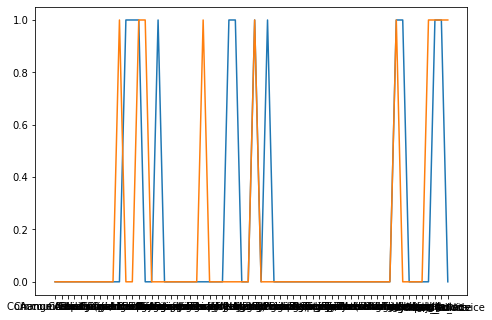

In [104]:
import matplotlib.pyplot as plt

def compare_people(mentor, mentee, compare="all", count_sims="no"):  
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    if compare == "want" or compare == "give":
        langs = list(df_want_mentee_final.columns)
        data_mentee = list(df_want_mentee_final.loc[mentee, : ])
        data_mentor = list(df_give_mentor_final.loc[mentor, : ])
    elif compare == "strengths":
        langs = list(df_strengths_mentee_final.columns)
        data_mentee = list(df_strengths_mentee_final.loc[mentee, : ])
        data_mentor = list(df_strengths_mentor_final.loc[mentor, : ])
    elif compare == "interests":
        langs = list(df_interests_mentee_final.columns)
        data_mentee = list(df_interests_mentee_final.loc[mentee, : ])
        data_mentor = list(df_interests_mentor_final.loc[mentor, : ])   
    else:
        langs = list(df_onehot_mentee.columns)
        data_mentee = list(df_onehot_mentee.loc[mentee, : ])
        data_mentor = list(df_onehot_mentor.loc[mentor, : ])
    if count_sims != "no":
        count = sum(1 for i, j in zip(data_mentee, data_mentor) if i == j)
        print(str(count) + "/" + str(len(data_mentee)))
    plt.plot(langs, data_mentee)
    plt.plot(langs, data_mentor)
    

compare_people("Tijana Pejnovic", "Ana Tojeiro", count_sims="yes")
#ax.bar(langs, data)
plt.show()

45/62


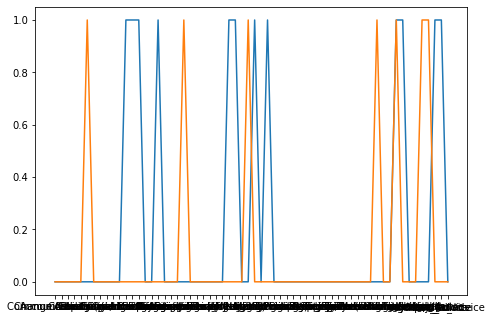

In [105]:
compare_people("Octavian Preda", "Ana Tojeiro", count_sims="yes")